# Customer Churn

## Introduction
The Telco Customer Churn dataset is a fictional dataset created by the IBM Watson Analytics community and can be found on Kaggle at https://www.kaggle.com/datasets/blastchar/telco-customer-churn. The dataset contains various data on customers for an imaginary telecommunications company named Telco. The ojective it to attempt to predict whether or not customers will churn (cancel their services with the company) in the future based on various data that we have on that customers.
<br>

As the response is whether or not customers churn, we will approach this dataset with a few different categorical methods and compare how they perform against another. The models include a logistic regression model, a naive bayes model, a decision tree model and a random forests model. For each model, we will fit a full model and will also fit a reduced models using Chi2 criteria for feature selection. We'll then compare and discuss the caveats of each model.

In [1]:
import numpy as np
import pandas as pd

#import the csv
churn = pd.read_csv('Customer-Churn.csv')

# Blank total charges are replaced with None
churn.loc[churn.TotalCharges == ' ', 'TotalCharges'] = None

# We need to make sure that our data are of the right type - most are categorical but some are numeric
categoricals = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
quants = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Assign the correct datatype to both responses and predictors
churn['Churn'] = churn['Churn'].astype('category')
for i in categoricals:
    churn[i] = churn[i].astype('category')
for j in quants:
    churn[j] = churn[j].astype('float64')

churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   float64 
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

## Data Description
The dataset contains 7,043 observations (with each observation corresponding to a customer) and there are a total 21 columns in the dataset, which are shown above. The first column is the customer ID, which is essentially an index and can be left alone for now. The following 19 columns contain data on various attributes of the customer and can be treated as explanatory variables (or features). The final column is customer churn, which can be treated as a binary response variable that indicates whether or not customer churn occurred. The majority (16) of the explanatory variables are categorical variables – with two to four categories each and a labeled as 'category' above while the three quantitative variables (tenure, MonthlyCharges, & TotalCharges) are labeled float 64.

<br>

We will take a machine learning approach when dealing with this dataset. We will use four classification models to predict customer churn by splitting our dataset into a training set and a testing set. We'll train each set on the training set before applying them to the testing set and compare how well each performed as well as some caveats to each model. When fitting a model, we will first fit a full model using (almost) all of the features above and we will also fit a reduced model using Chi2 criteria for feature selection (giving us a total of 8 models).

## Cleaning the data

We need to clean the data up a bit before analyzing it. We can go ahead and start of by printing out the first few lines of the dataset as well as checking the columns for NA values.

In [2]:
churn.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8.0,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,1452-KIOVK,Male,0,No,Yes,22.0,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,6713-OKOMC,Female,0,No,No,10.0,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,7892-POOKP,Female,0,Yes,No,28.0,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62.0,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
churn.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

There are just 11 NAs contained in the dataset - all under TotalCharges. Looking at the first 10 rows of data, we should consider which of these features are actually important to the anlysis - some also appear they may be redundant. For example, looking at the first row, we see that this individual's tenure is 1 month and has identical values for their MonthlyCharges and TotalCharges indicating that Total Charges is likely just a function of tenure and monthly charges. If we plot TotalCharges against MonthlyCharges\*Tenure on a scatterplot, we see that the two features display a near perfect linear relationship.

The correlation coefficient between Monthly Charges times Tenure and Total Charges is 0.9996


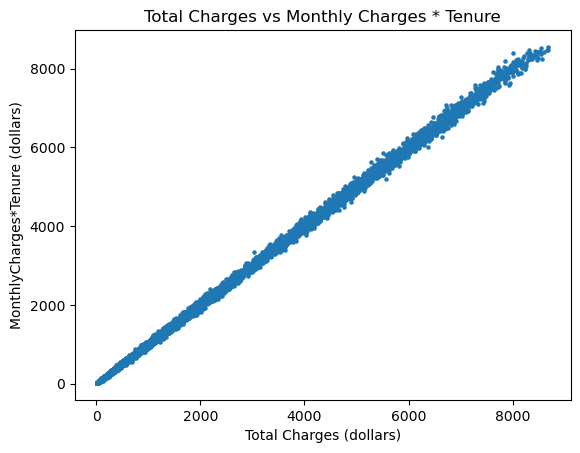

In [4]:
from matplotlib import pyplot as plt

churn_rmna = churn.dropna(axis = 0).copy()
x = churn_rmna.TotalCharges
y = churn_rmna.MonthlyCharges * churn_rmna.tenure

print('The correlation coefficient between Monthly Charges times Tenure and Total Charges is {}'.format(
    round(np.corrcoef(x, y)[0][1],4)))
plt.scatter(x, y, alpha = 1, s = 5);
plt.title("Total Charges vs Monthly Charges * Tenure")
plt.xlabel("Total Charges (dollars)")
plt.ylabel("MonthlyCharges*Tenure (dollars)");

Since this would certainly cause issues with multicollinearity, we should remove one of the variables. Since TotalCharges contains missing values and is also less informative (it's easy to determine TotalCharges from Tenure and MonthlyCharges but impossible to do the reverse) it's best get rid of it while retaining Monthly Charges and Tenure. Customer ID can also be removed as it would have no reasonable affect on whether customer churn occurs or not.

In [5]:
churn.drop(['TotalCharges', 'customerID'], axis=1, inplace = True)

In [6]:
# For consistency's sake, we will convert the 0s and 1s to No and Yes to match other categories

churn['SeniorCitizen'].replace(0, 'No', inplace = True)
churn['SeniorCitizen'].replace(1, 'Yes', inplace = True)

X = churn.iloc[:,0:18]
y = churn.iloc[:,18]

In [7]:
churn.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,No,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,No,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,No,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,No,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,No,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes
5,Female,No,No,No,8.0,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,Yes
6,Male,No,No,Yes,22.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,No
7,Female,No,No,No,10.0,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,No
8,Female,No,Yes,No,28.0,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,Yes
9,Male,No,No,Yes,62.0,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,No


Next we will need to import some libraries in order to split the dataset up and preprocess the data. Since the machine learning algorithm requires numeric values we need to encode our data. We will be using LabelEncoder and OrdinalEncoder From scikit-lean (LabelEncoder is used for encoding the tartget variable - customer churn, while OrdinalEncoded is used for converting our features). One thing we need to be careful about is to not convert 

In [8]:
# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

# Function for converting the categorical values to numerics to prepare for the ML algorithm

def convert_to_value(X, y):
    inputs = OrdinalEncoder()
    inputs.fit(X)
    outputs = LabelEncoder()
    outputs.fit(y)
    X_val = inputs.transform(X)
    y_val = outputs.transform(y)
    return X_val, y_val

In [9]:
from sklearn.model_selection import train_test_split

# Split the dataset into a training and testing dataset (seed set the same as above so as to assign in the same fashion)
seed = np.random.randint(1,1000000)
np.random.seed(41623)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4)

# Use the function convert the test and training datasets
test_X_cd, test_y_cd = convert_to_value(test_X, test_y)
train_X_cd, train_y_cd = convert_to_value(train_X, train_y)

TO DO : Go into details about how the encoding works and check if it's okay that 2 are quantitative

# Full Models
In the following section, we will test the four models using all of the features contained in our dataset (except for the two that we removed at the start). The 4 models that we will be using are:

- Naive Bayes
- Logistic Regression
- Decision Trees
- Random Forest

All four of these models are used for classifying categorical predictors and are examples of supervised learning (i.e. they require labeled inputs and outputs). 

&emsp;This is an example.

### Naive Bayes - Full Model

 The Naive Bayes model is a relatively simple technique for classifying observations based upon Thomas Bayes' famous formula:

$$ P(B|A) = \frac{P(A|B)P(B)}{P(A)}$$


This conditional probability is used to assign labels to observations based on the likelihood of each label according to feature data. In our case, since we are trying to determine whether or not customer churn occurs, we essentially have two conditional probabilities for each observation:

$$ P(\mbox{Churn}|\mbox{features}) = \frac{P(\mbox{features}|\mbox{Churn})P(\mbox{Churn})}{P(\mbox{features})}$$ &emsp;  $$P(\mbox{No Churn}|\mbox{features}) = \frac{P(\mbox{features}|\mbox{No Churn})P(\mbox{No Churn})}{P(\mbox{features})}$$


which, if we use the likelihood of these two, reduces to 


$$ \frac{P(\mbox{Churn}|\mbox{features})}{P(\mbox{No Churn}|\mbox{features})} = \frac{P(\mbox{features}|\mbox{Churn})}{P(\mbox{features}|\mbox{No Churn})} \frac{P(\mbox{Churn})}{P(\mbox{No Churn})}$$



ion with certain features. Recall, that the features in SciKit-Learn are the predictor values of an observation. If we could compute the likelihood of each possible label we could compare those likelihoods and pick the most likely one. The likelihood is 

$$ P(\mbox{label}|\mbox{features}) = \frac{P(\mbox{features}|\mbox{label})P(\mbox{label})}{P(\mbox{feature})}$$

If we're trying to decide which of two labels, say $L_1$ and $L_2$ is more likely, then we would compare the likelihoods 

$$ \frac{P(\mbox{L_1}|\mbox{features})}{P(\mbox{L_2}|\mbox{features})} = \frac{P(\mbox{features}|\mbox{L_1})}{P(\mbox{features}|\mbox{L_2})} \frac{P(L_1)}{P(L_2)}$$

Since the features of the observations are the same in both cases, those terms cancel out. We need to be able to find the probability of specific features for observations in each group (differentiated by the labels). In a "Naive Bayes" model, naive (simple) assumptions are made about how these observations are generated. That allows us to state a model that generates features in each group and to compute probabilities for each of the features.

Below we fit the Naive Bayes full model to the training data and then run it on the testing data and create a confusion matrix to assess how well the model performed. An example of what is told in a confusion matrix is shown below.

- True negative: when the model correctly identifies no churn
- False negative: when the model incorrectly predicts no churn, but churn occurs
- True positive: when the model correctly identifies churn
- False positive: when the model incorrectly predicts churn, but no churn occurs


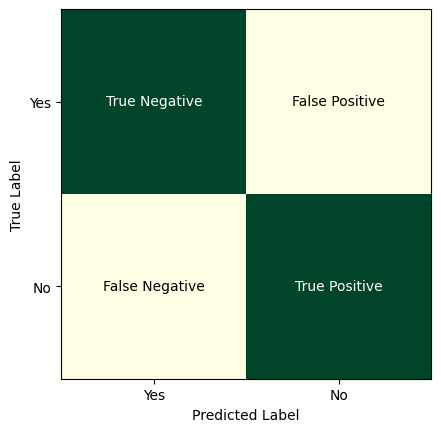

In [10]:
fig, ax = plt.subplots()
ax.imshow([[5,1],[1,5]], cmap = 'YlGn')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.text(0,0, 'True Negative', ha="center", va="center", color="w")
ax.text(1,0, 'False Positive', ha="center", va="center", color="k")
ax.text(0,1, 'False Negative', ha="center", va="center", color="k")
ax.text(1,1, 'True Positive', ha="center", va="center", color="w");


There are quite a few metrics associated with these four values. Three that we will focus on here are accuracy, specificity, and sensitivity. Accuracy simply measure how many times the model was correct out of how many observations: 

$$ \text{Accuracy} = \frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}}, $$

Sensitivity reveals how well the model is able to detect true positive and is the conditional probability of a positive result given that the observation is truly positive (e.g. probability of identifying customer churn given that the customer will churn). We calculate it:

$$ \text{Sensitivity} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}, $$

Specificity is used for determining how well the model was at correctly identifying negative results (no customer churn). This is also a conditional probability which tells us the probability that a customer will not churn given that they don't churn.

$$ \text{Specificity} = \frac{\text{True Negative}}{{\text{True Negative} + \text{False Positive}}} $$


The accuracy of the Naive Bayes model with all features is 0.736


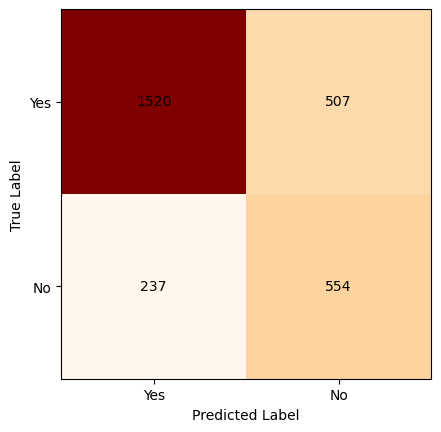

In [11]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

model = BernoulliNB()
model.fit(train_X_cd, train_y_cd)
predictions = model.predict(test_X_cd)

acc_fm_nb = model.score(test_X_cd, test_y_cd)

print('The accuracy of the Naive Bayes model with all features is {}'.format(
    round(acc_fm_nb,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

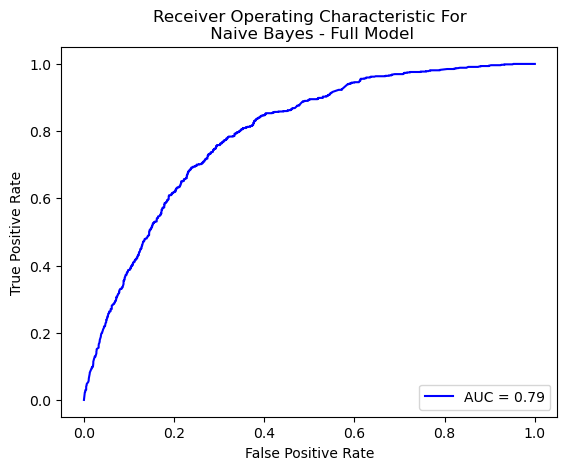

In [12]:
from sklearn import metrics

predict_prob = model.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Naive Bayes - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Logistic Regression - Full Model

The accuracy of the Logistic Regression model with all features is 0.787


/Users/Evan/anaconda3/envs/MySQL_connect/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


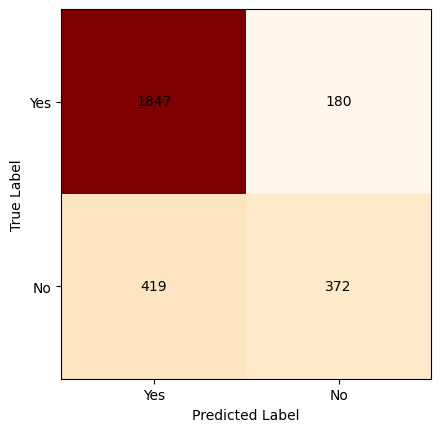

In [13]:
from sklearn import linear_model

# The full model with no variables removed - but all features have been 
# transformed into categorical features

from sklearn import linear_model
reg = linear_model.LogisticRegression()
reg.fit(train_X_cd, train_y_cd)
predictions = reg.predict(test_X_cd)

acc_fm_lr = reg.score(test_X_cd, test_y_cd)

print('The accuracy of the Logistic Regression model with all features is {}'.format(
    round(acc_fm_lr ,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

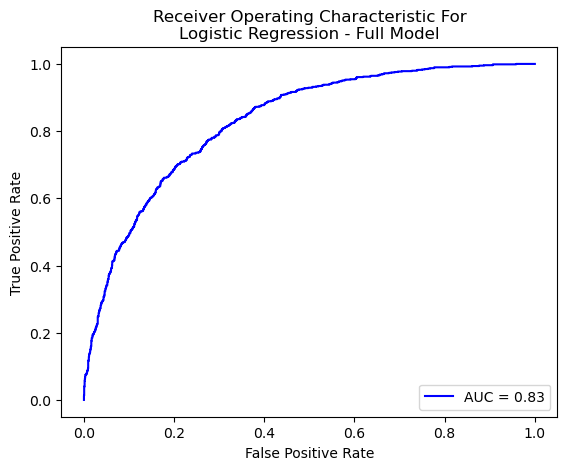

In [14]:
predict_prob = reg.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\nLogistic Regression - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Decision Trees - Full Model

The accuracy of the test was 0.764


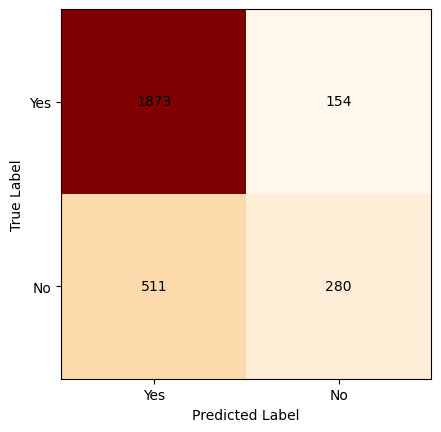

In [15]:
from sklearn.tree import DecisionTreeClassifier 

# Using a Decision tree with the maximum depth set to 4 to contrast with the above
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(train_X_cd, train_y_cd)

predictions = tree.predict(test_X_cd)

acc_fm_dt = tree.score(test_X_cd, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_fm_dt,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

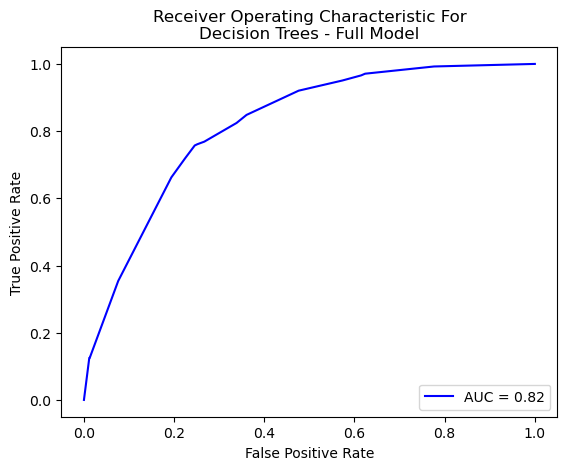

In [16]:
predict_prob = tree.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\nDecision Trees - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Random Forests - Full Model

The accuracy of the test was 0.778


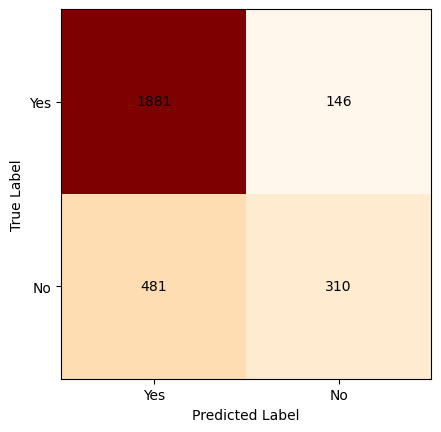

In [17]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(tree, n_estimators = 100, max_samples = 0.8, random_state = 1) # ensemble of many trees
bag.fit(train_X_cd, train_y_cd) # fit the ensemble to the data 

predictions = bag.predict(test_X_cd)

acc_fm_rf = bag.score(test_X_cd, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_fm_rf,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

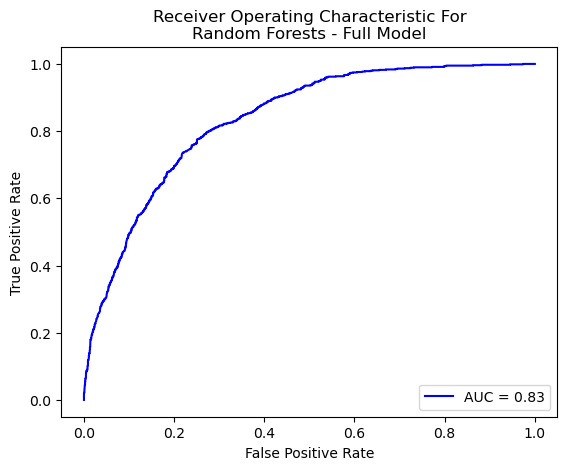

In [18]:
predict_prob = bag.predict_proba(test_X_cd)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\nRandom Forests - Full Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

# Feature Selection using Chi-Square Test

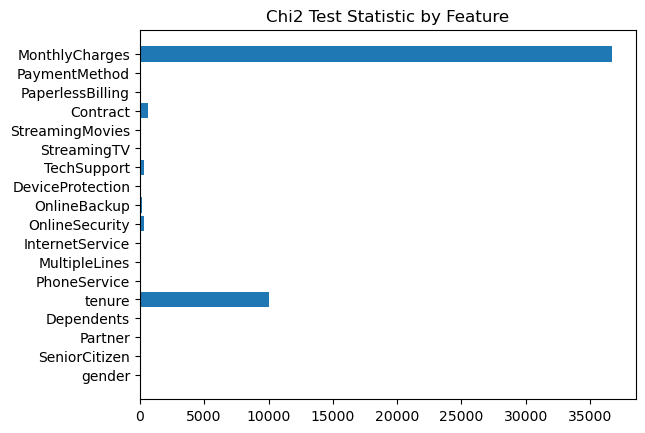

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# Using chi2 to score features and select the k top features
# Set the selection criteria to k = 4 features selected using Chi2 
def chi2_features(train_X, train_y, test_X):
    select = SelectKBest(score_func=chi2, k=4)
    select.fit(train_X, train_y)
    train_X_selection = select.transform(train_X)
    test_X_selection = select.transform(test_X)
    return train_X_selection, test_X_selection, select

# Using the function above to select the most important features based on the chi2 criteria
# and assigning these arrays to be inputted into the logistic regression model
X_train_select, X_test_select, chi2_select = chi2_features(train_X_cd, train_y_cd, test_X_cd)

# Print statement giving the chi2 test statistics for each feature
#for i in range(len(chi2_select.scores_)):
#    print('The feature {} has a score of {}'.format(train_X.columns[i], round(chi2_select.scores_[i], 3)))

# Bar plot showing the test statistic for each feature
plt.barh([i for i in range(len(chi2_select.scores_))], chi2_select.scores_)
plt.yticks(range(18), train_X.columns)
plt.title('Chi2 Test Statistic by Feature');

### Naive Bayes

The accuracy of the test was 0.731


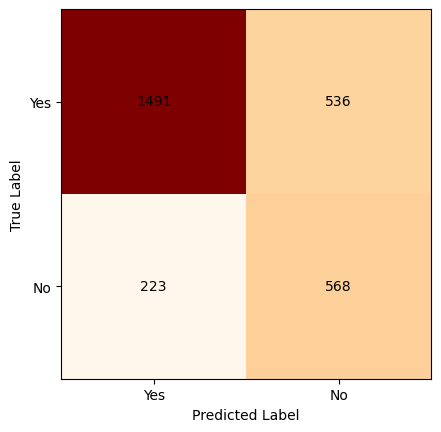

In [20]:
model = BernoulliNB()
model.fit(X_train_select, train_y_cd)
predictions = model.predict(X_test_select)

acc_chi_nb = model.score(X_test_select, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_chi_nb,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

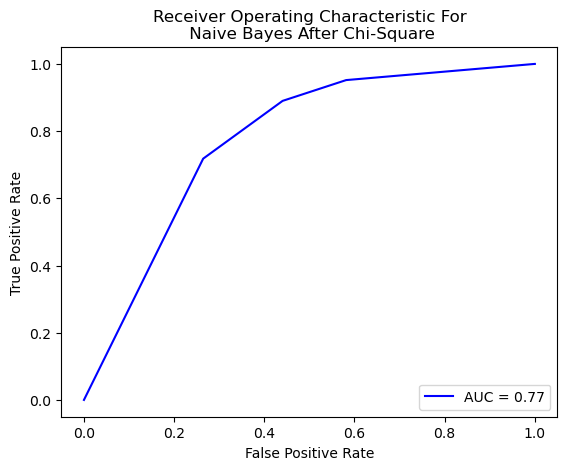

In [21]:
predict_prob = model.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Naive Bayes After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Logistic Regression

The accuracy of the test was 0.783 and the model included the features tenure, OnlineSecurity, Contract, MonthlyCharges


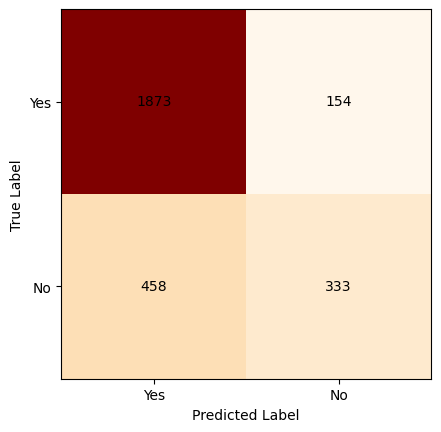

In [22]:
# Fit the logistic regression model
reg = linear_model.LogisticRegression()
reg.fit(X_train_select, train_y_cd)
predictions = reg.predict(X_test_select)

# Use the output of the function above create a dataframe of the selected features
features_c2 = chi2_select.get_support(indices=True)
features_c2_df = train_X.iloc[: ,features_c2]

# Print statement giving the accuracy of the model and which features were used

acc_chi_lr = reg.score(X_test_select, test_y_cd)

print('The accuracy of the test was {} and the model included the features {}'.format(
    round(acc_chi_lr ,3),
    ', '.join(features_c2_df.columns.values)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

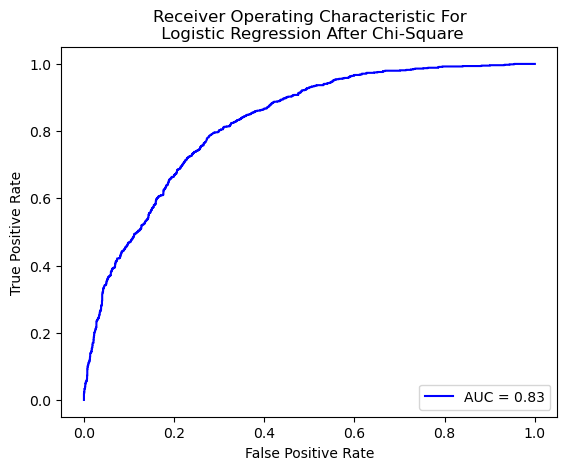

In [23]:
predict_prob = reg.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Logistic Regression After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Decision Tree

The accuracy of the test was 0.764


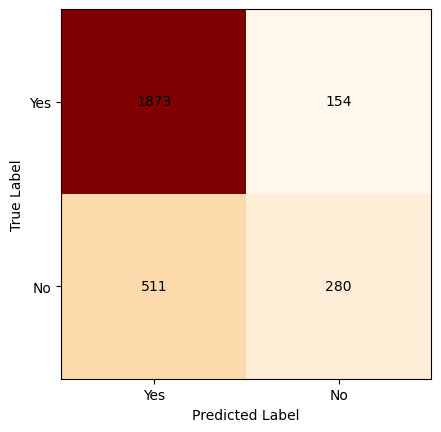

In [24]:
# Using a Decision tree with the maximum depth set to 4 to contrast with the above
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train_select, train_y_cd)

predictions = tree.predict(X_test_select)

acc_chi_dt = tree.score(X_test_select, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_chi_dt,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

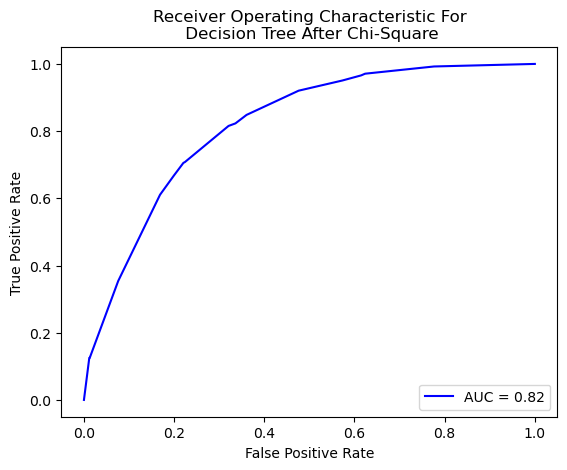

In [25]:
predict_prob = tree.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Decision Tree After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

### Random Forest 

The accuracy of the test was 0.778


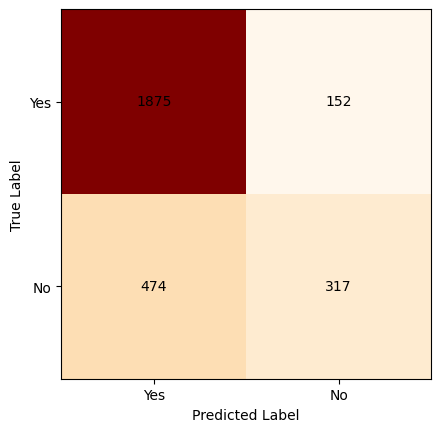

In [26]:
bag = BaggingClassifier(tree, n_estimators = 100, max_samples = 0.8, random_state = 1) # ensemble of many trees

bag.fit(X_train_select, train_y_cd) # fit the ensemble to the data 

predictions = bag.predict(X_test_select)

acc_chi_rf = bag.score(X_test_select, test_y_cd)

print('The accuracy of the test was {}'.format(
    round(acc_chi_rf,3)))

mat = confusion_matrix(test_y_cd, predictions)

fig, ax = plt.subplots()
ax.imshow(mat, cmap = 'OrRd')
ax.set_xticks(np.arange(len(set(train_y))))
ax.set_yticks(np.arange(len(set(test_y))))
ax.set_xticklabels(set(train_y))
ax.set_yticklabels(set(test_y))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

for i in range(len(set(test_y))):
    for j in range(len(set(train_y))):
        text = ax.text(j, i, mat[i, j], ha="center", va="center", color="k");

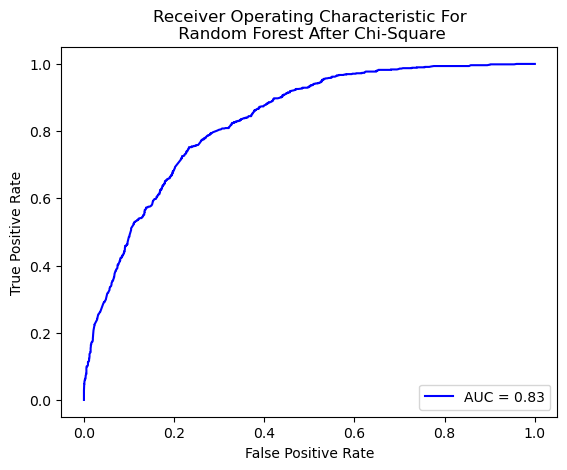

In [27]:
predict_prob = bag.predict_proba(X_test_select)[::,1]
fpr, tpr, threshold = metrics.roc_curve(test_y_cd, predict_prob)
roc_auc = metrics.auc(fpr, tpr)

# create the ROC plot with the area under the curve shown
plt.title('Receiver Operating Characteristic For\n Random Forest After Chi-Square')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

In [28]:
pd.DataFrame([[acc_fm_nb, acc_fm_lr, acc_fm_dt, acc_fm_rf],
            [acc_chi_nb, acc_chi_lr, acc_chi_dt, acc_chi_rf]], 
             index = ['Full Model', 'Chi2 Criteria'],
            columns = ['Naive Bayes', 'Logistic Regression', 'Decision Trees', 'Random Forests'])

,Naive Bayes,Logistic Regression,Decision Trees,Random Forests
Full Model,0.735983,0.787438,0.764017,0.777502
Chi2 Criteria,0.730660,0.782825,0.764017,0.777857
